<a href="https://colab.research.google.com/github/mschoene/emoClassif/blob/main/Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Emotion classification of Tweets

---

In the following notebook tweets will be categorized into 6 emotions
* Sadness
* Joy
* Love
* Anger
* Fear
* Surprise

Five different classifiers are trained
*    Naive Bayes
*    Support vector machine (SVM)
*    Random Forest
*    Logistic Regression
*    Homebrew neural network

# Loading of dataset and imports

The dataset is loaded from https://huggingface.co/datasets/dair-ai/emotion


In [22]:
!pip install datasets

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [24]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch'])
except ImportError:
    pass

In [25]:
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics

from skorch import NeuralNetClassifier

In [26]:
datasets = load_dataset('dair-ai/emotion')

In [27]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [28]:
train = pd.DataFrame(datasets['train'])
test = pd.DataFrame(datasets['test'])
validation = pd.DataFrame(datasets['validation'])

In [29]:
train.describe

<bound method NDFrame.describe of                                                     text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]>

In [30]:
class_labels = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# Data Vizalisazion

In [31]:
train.groupby('label').size()/ float(train["text"].shape[0]) *100

label
0    29.16250
1    33.51250
2     8.15000
3    13.49375
4    12.10625
5     3.57500
dtype: float64

The statistics per class vary drastically from almost 1/3 down to 3%. It is expected that this will influence the per class performance of the classifiers. See below for a figure of the statistics.

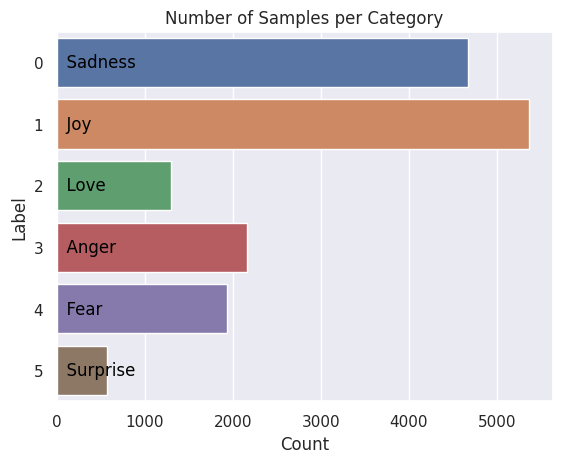

In [32]:
sns.set_theme()
ax = sns.countplot(data=train, y="label")
sns.set_palette(sns.color_palette("husl",6))

# Set title and labels
ax.set_title('Number of Samples per Category')
ax.set_ylabel('Label')
ax.set_xlabel('Count')

for label in train['label'].unique():
    count = len(train[train['label'] == label])
    text = "  " + class_labels[label] #small little ofset before label so it is not flush to the axis
    ax.text(0, label, text, ha='left', va='center', fontsize=12, color='black')

In [33]:
# get the lenght of the tweets
text_len = np.array([len(tweet) for tweet in train["text"]])

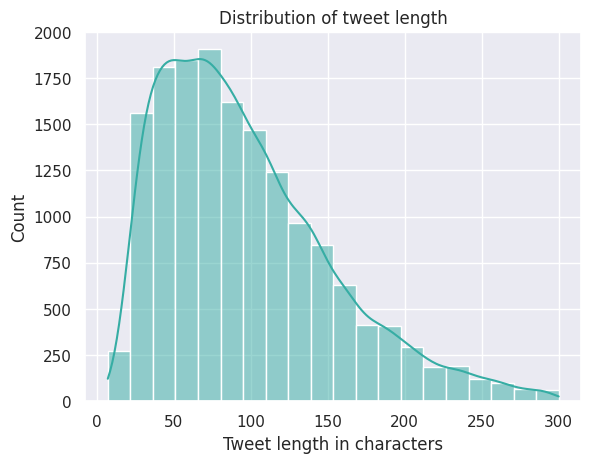

In [34]:
sns.set_palette(sns.color_palette("husl",6)[3:])
ax = sns.histplot(data=text_len, kde=True, bins=20).set(xlabel="Tweet length in characters", title="Distribution of tweet length")

In [35]:
X_train = train.text
y_train = train.label
X_test = test.text
y_test = test.label
X_valid = validation.text
y_valid = validation.label

In [36]:
def print_classification_report(test,pred):
    '''Function for pretty printing of classification report'''
    report = metrics.classification_report(test, pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(test, pred)))

# Finding a good classifier

## Grid search with multiple classifiers

Four different classifiers were tested first:
*    Naive Bayes
*    Support vector machine (SVM)
*    Random Forest
*    Logistic Regression


In [37]:
# Define classifiers
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grid = {
  'vect__ngram_range': [(1,2),(1,1)],
  'vect__max_features': [2000,4000],
}

#store the classifier name, accuracy and best parameters
accMo = []

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer( )),
    ( name, classifier )
    ])

    text_clf_gs = GridSearchCV(text_clf, param_grid, cv=5, verbose=0)
    text_clf_gs.fit(X_train, y_train)

    best_params = text_clf_gs.best_estimator_.get_params()
    y_pred = text_clf_gs.best_estimator_.predict(X_valid)

    # Evaluate the classifier
    accuracy = accuracy_score(y_valid, y_pred)
    report = classification_report(y_valid, y_pred)

    for param_name in sorted(param_grid.keys()):
        print(f"{param_name}: {best_params[param_name]}")

    accMo.append((name, accuracy, text_clf_gs.best_params_ ))
    print("="*40)
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print_classification_report(y_valid,y_pred)
    print("="*40)

vect__max_features: 2000
vect__ngram_range: (1, 1)
Classifier: Naive Bayes
Accuracy: 0.7690
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       550
           1       0.73      0.97      0.84       704
           2       0.98      0.27      0.42       178
           3       0.94      0.64      0.76       275
           4       0.89      0.51      0.65       212
           5       1.00      0.09      0.16        81

    accuracy                           0.77      2000
   macro avg       0.88      0.57      0.61      2000
weighted avg       0.81      0.77      0.74      2000

accuracy: 0.769
vect__max_features: 2000
vect__ngram_range: (1, 1)
Classifier: SVM
Accuracy: 0.8720
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       550
           1       0.85      0.96      0.90       704
           2       0.92      0.64      0.75       178
           3       0.92      0.80      0.86     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

vect__max_features: 2000
vect__ngram_range: (1, 1)
Classifier: Logistic Regression
Accuracy: 0.8700
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       550
           1       0.85      0.95      0.90       704
           2       0.90      0.68      0.77       178
           3       0.92      0.84      0.87       275
           4       0.86      0.75      0.80       212
           5       0.85      0.62      0.71        81

    accuracy                           0.87      2000
   macro avg       0.87      0.79      0.83      2000
weighted avg       0.87      0.87      0.87      2000

accuracy: 0.870


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
accMo

[('Naive Bayes',
  0.769,
  {'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}),
 ('SVM', 0.872, {'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}),
 ('Random Forest',
  0.883,
  {'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}),
 ('Logistic Regression',
  0.87,
  {'vect__max_features': 2000, 'vect__ngram_range': (1, 1)})]

Below a confusion matrix for the last classifier (logistic regression) on the validation set.

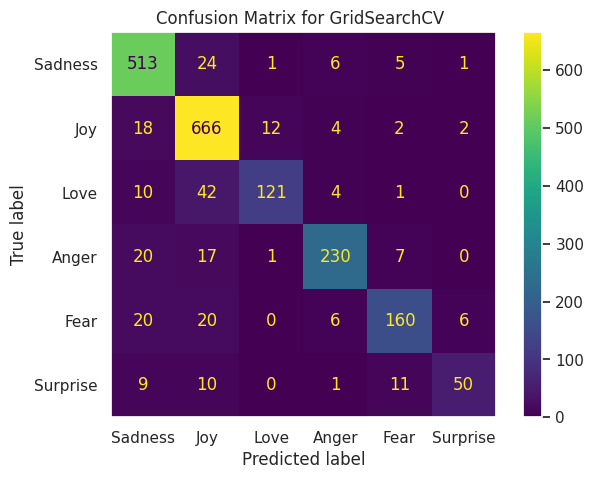

In [39]:
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, ax=ax)
_ = ax.set_title(
    f"Confusion Matrix for {text_clf_gs.__class__.__name__} " )
ax.set_xticklabels([class_labels[i] for i in range(len(class_labels))])
ax.set_yticklabels([class_labels[i] for i in range(len(class_labels))])

ax.grid(visible=False)

## Neural Network

A feedforward neural network is trained in the following.

In [20]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=100,
            num_inputs=100,
            num_outputs=len(np.unique(y_train)),
            nonlin=F.relu,
    ):
        super(ClassifierModule, self).__init__()
        print(f"num_inputs {num_inputs}, num_units {num_units}, nonlin {nonlin}")
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(num_inputs, num_units*8)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units*8, num_units*4)
        self.dense2 = nn.Linear(num_units*4, num_units*2)
        self.dense3 = nn.Linear(num_units*2, num_units)

        self.output = nn.Linear(num_units, num_outputs)

    def forward(self, X, **kwargs):
      X = self.nonlin(self.dense0(X))
      X = self.nonlin(self.dense1(X))
      X = self.nonlin(self.dense2(X))
      X = self.nonlin(self.dense3(X))
      X = self.output(X)
      X = F.log_softmax(X, dim=1)
      return X

In [21]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    criterion=nn.CrossEntropyLoss(),
    lr=0.05,
    #device='cuda',  # comment this to train with CPU
)

In [22]:
text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1, 2), max_features=1000,  binary=True, stop_words='english')),
    #('tfidf', TfidfTransformer()), # NN fails to converge when features are normalized
    ('float32', FunctionTransformer(func=lambda x_train: x_train.astype(np.float32), validate=False)),
    ('nn', net ) ])


In [23]:
param_grid = [{
            'vect__ngram_range': [(1,2),(1,3)],   # unigrams were also tested but were not favored by the model
            'vect__max_features': [4000],         # number of vectorizer features == size of input into nn
            'nn__module__num_inputs': [4000],     # number of vectorizer features == size of input into nn ie nn__module__num_inputs == vect__max_features
            'nn__module__num_units': [128,256],
            'nn__module__nonlin': [F.elu],        # F.relu was also tested but for the sake of the grid search not taking forever it is not redone here
            'nn__lr': [ 0.05]
} ]

text_clf_gs = GridSearchCV(text_clf, param_grid=param_grid, cv=5, verbose=1)
text_clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
num_inputs 4000, num_units 128, nonlin <function elu at 0x7945e66b2200>
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6574       0.3352        1.5897  7.1889
      2        1.5803       0.3352        1.5767  6.9484
      3        1.5751       0.3352        1.5748  6.0919
      4        1.5739       0.3352        1.5741  6.9860
      5        1.5732       0.3352        1.5735  6.1422
      6        1.5725       0.3352        1.5729  6.9368
      7        1.5717       0.3352        1.5723  6.2330
      8        1.5708       0.3352        1.5715  6.8693
      9        1.5697       0.3352        1.5705  6.1125
     10        1.5683       0.3352        1.5692  6.9728
     11        1.5666       0.3352        1.5676  6.3870
     12        1.5642       0.3363        1.5653  6.6954
     13        1.5609       0.3453        1.5621  6.9335
     14      

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(analyzer='char',
                                                        binary=True,
                                                        max_features=1000,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('float32',
                                        FunctionTransformer(func=<function <lambda> at 0x79462a20f880>)),
                                       ('nn',
                                        <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ClassifierModule'>,
))]),
             param_grid=[{'nn__lr': [0.05],
                          'nn__module__nonlin': [<function elu at 0x7945e66b2200>],
                          'nn__module__num_inputs': [4000],
                          'nn__module__num_units': [128, 256],
                          'vect__analyzer': ['word'],
                          'vect__max_features': [4000],
                          'vect__ngram_range': [(1, 2), (1, 3)]}],
             verbose=1)

In [35]:
text_clf_gs.best_score_

0.8560625

In [34]:
text_clf_gs.best_params_

{'nn__lr': 0.05,
 'nn__module__nonlin': <function torch.nn.functional.elu(input: torch.Tensor, alpha: float = 1.0, inplace: bool = False) -> torch.Tensor>,
 'nn__module__num_inputs': 4000,
 'nn__module__num_units': 128,
 'vect__analyzer': 'word',
 'vect__max_features': 4000,
 'vect__ngram_range': (1, 2)}

In [25]:
y_pred = text_clf_gs.best_estimator_.predict(X_valid)

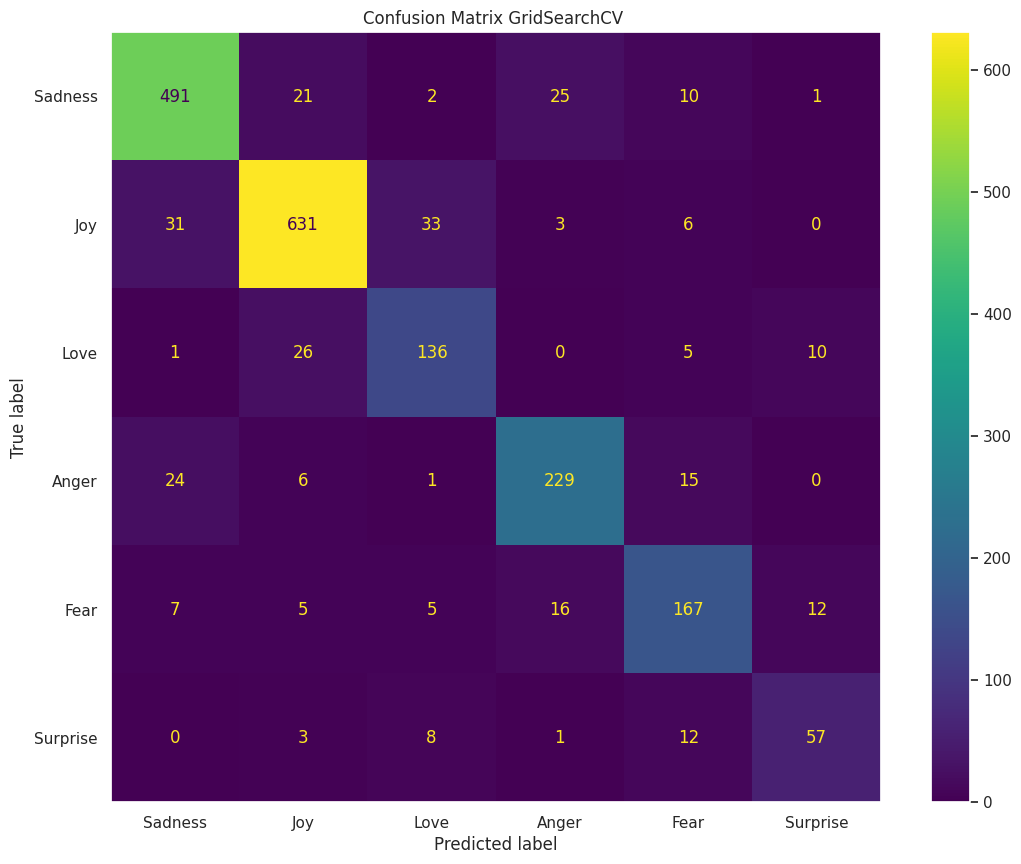

In [26]:
fig2, ax2 = plt.subplots(figsize=(13, 10))
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, ax=ax2)
_ = ax2.set_title(f"Confusion Matrix {text_clf_gs.__class__.__name__} " )

ax2.set_xticklabels([class_labels[i] for i in range(len(class_labels))])
ax2.set_yticklabels([class_labels[i] for i in range(len(class_labels))])
ax2.grid(visible=False)

In [27]:
print_classification_report(y_valid,y_pred)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       550
           1       0.91      0.90      0.90       704
           2       0.74      0.76      0.75       178
           3       0.84      0.83      0.83       275
           4       0.78      0.79      0.78       212
           5       0.71      0.70      0.71        81

    accuracy                           0.86      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.86      0.86      0.86      2000

accuracy: 0.856


# Final Results

The best model from above is chosen and retrained on the sum of the training and validation datasets. Then the performance is reevaluated on the test set.

In [28]:
X_train.shape

(16000,)

In [29]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])
X_train.shape
y_train.shape

(18000,)

In [30]:
goat = text_clf_gs.best_estimator_.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: nonlin, num_inputs, num_units.
num_inputs 4000, num_units 128, nonlin <function elu at 0x7945e66b2200>
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6415       0.3369        1.5837  9.4710
      2        1.5786       0.3369        1.5756  8.6586
      3        1.5752       0.3369        1.5742  9.4419
      4        1.5742       0.3369        1.5735  9.4414
      5        1.5735       0.3369        1.5727  9.5313
      6        1.5726       0.3369        1.5718  8.6333
      7        1.5715       0.3369        1.5707  9.4661
      8        1.5701       0.3369        1.5692  9.5173
      9        1.5681       0.3369        1.5671  9.4668
     10        1.5653       0.3369        1.5639  9.0127
     11        1.5608       0.3369        1.5587  9.2554
     12        1.5529       0.343

Finally the test data is used for the results.

In [31]:
y_pred = goat.predict(X_test)

In [32]:
print_classification_report(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       581
           1       0.90      0.90      0.90       695
           2       0.70      0.75      0.72       159
           3       0.86      0.81      0.84       275
           4       0.84      0.85      0.84       224
           5       0.69      0.68      0.69        66

    accuracy                           0.87      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.87      0.87      0.87      2000

accuracy: 0.866


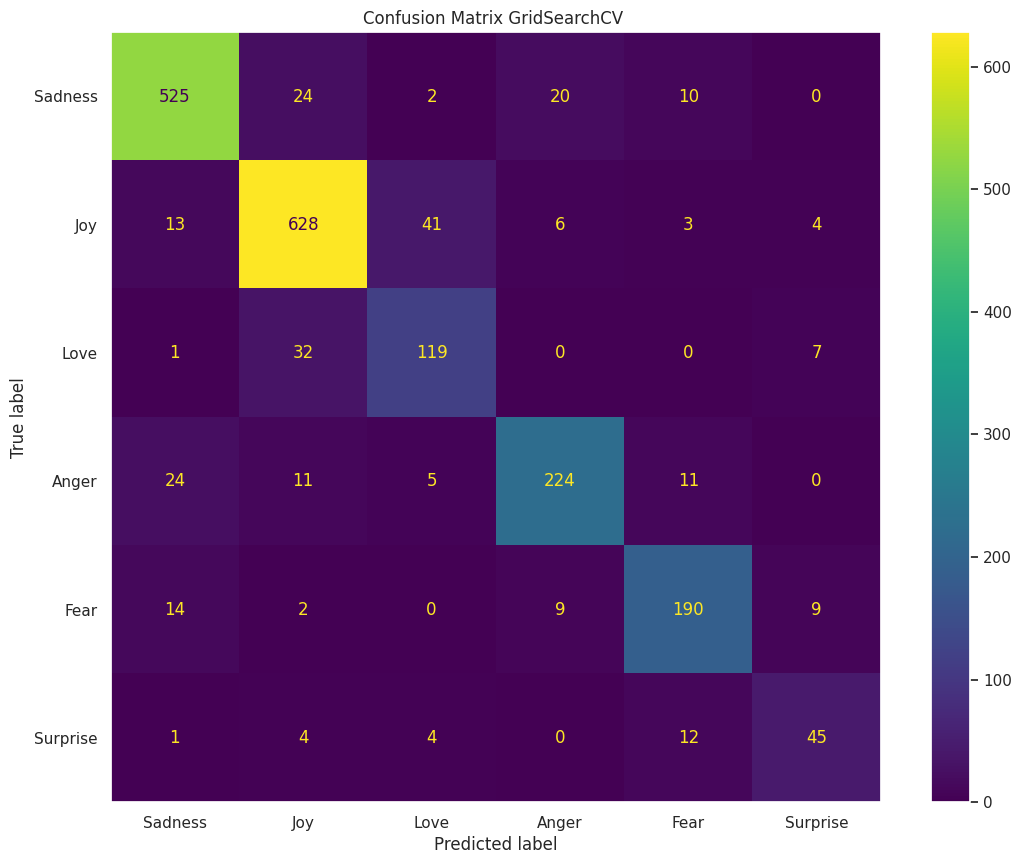

In [33]:
fig2, ax2 = plt.subplots(figsize=(13, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax2)
_ = ax2.set_title(f"Confusion Matrix {text_clf_gs.__class__.__name__} " )

ax2.set_xticklabels([class_labels[i] for i in range(len(class_labels))])
ax2.set_yticklabels([class_labels[i] for i in range(len(class_labels))])
ax2.grid(visible=False)

In [37]:
misclassified_examples = []

for i in range(len(y_test)):
    true_label = y_test[i]
    predicted_label = y_pred[i]

    if true_label == 4 and predicted_label == 5:  # True label is fear 4, predicted label is surprise 5
        misclassified_examples.append((i, true_label, predicted_label))

    if true_label == 5 and predicted_label == 4:  # True label is surprise 5, predicted label is fear 4
        misclassified_examples.append((i, true_label, predicted_label))

for example in misclassified_examples:
    index, true_label, predicted_label = example
    print(f"Example: {X_test[index]}: True Label - {true_label}, Predicted Label - {predicted_label}")

Example i was feeling weird the other day and it went away about minutes after i took my metformin: True Label - 4, Predicted Label - 5
Example i just feel are ludicrous and wasting space or so trite they should have looked at the book first and come up with something a little more original: True Label - 5, Predicted Label - 4
Example i feel like in the last year especially i ve gone from a girl to a woman and despite how hesitant i have always been about getting older next year i will be twenty four i am surprised at how pleased i am to have done so: True Label - 4, Predicted Label - 5
Example i am feeling overwhelmed by trying to do it all that i think on the women before me: True Label - 5, Predicted Label - 4
Example i woke up today feeling kind of strange: True Label - 4, Predicted Label - 5
Example i wept while jackson slept feeling overwhelmed by the feeling that i don t want to die: True Label - 4, Predicted Label - 5
Example i feel overwhelmed how about you: True Label - 5, Pr